You must run this notebook on a GPU. A T4 is sufficient. It's free on [Google
Colab](https://stackoverflow.com/questions/62596466/how-can-i-run-notebooks-of-a-github-project-in-google-colab/67344477#67344477).

**Description**: for a [GPTQd Mistral
7B](https://huggingface.co/TheBloke/Mistral-7B-OpenOrca-GPTQ) and the [Banking
77](https://huggingface.co/datasets/PolyAI/banking77) classification task (77 = number
of classes/choices), this notebook demonstrates that CAPPr gets you +3% absolute
accuracy compared to text generation and +5% compared to [guidance](https://github.com/guidance-ai/guidance). There is only a statistical benefit though.
Computationally, CAPPr is currently much slower when there are a lot of completions
which need to be mentioned in the context. On a bigger rig, CAPPr isn't too slow b/c we
can process completions in parallel. See [this
section](https://cappr.readthedocs.io/en/latest/computational_performance.html#weaknesses)
of the documentation.

**Estimated run time**: ~13 min.

In [1]:
# check correct CUDA version
import torch

_cuda_version = torch.version.cuda
_msg = (
    "Change the pip install auto-gptq command to the one for "
    f"{_cuda_version} based on the list here: "
    "https://github.com/PanQiWei/AutoGPTQ#quick-installation"
)

assert _cuda_version == "11.8", _msg

In [ ]:
!python -m pip install "cappr[demos] @ git+https://github.com/kddubey/cappr.git" \
auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/ \
optimum \
guidance

In [3]:
from __future__ import annotations
from typing import Sequence

import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.calibration import calibration_curve
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import guidance

from cappr import huggingface as hf

# Load data

In [4]:
df = pd.DataFrame(datasets.load_dataset("PolyAI/banking77", split="train"))

In [5]:
original_class_names = ["Refund_not_showing_up", "activate_my_card", "age_limit", "apple_pay_or_google_pay", "atm_support", "automatic_top_up", "balance_not_updated_after_bank_transfer", "balance_not_updated_after_cheque_or_cash_deposit", "beneficiary_not_allowed", "cancel_transfer", "card_about_to_expire", "card_acceptance", "card_arrival", "card_delivery_estimate", "card_linking", "card_not_working", "card_payment_fee_charged", "card_payment_not_recognised", "card_payment_wrong_exchange_rate", "card_swallowed", "cash_withdrawal_charge", "cash_withdrawal_not_recognised", "change_pin", "compromised_card", "contactless_not_working", "country_support", "declined_card_payment", "declined_cash_withdrawal", "declined_transfer", "direct_debit_payment_not_recognised", "disposable_card_limits", "edit_personal_details", "exchange_charge", "exchange_rate", "exchange_via_app", "extra_charge_on_statement", "failed_transfer", "fiat_currency_support", "get_disposable_virtual_card", "get_physical_card", "getting_spare_card", "getting_virtual_card", "lost_or_stolen_card", "lost_or_stolen_phone", "order_physical_card", "passcode_forgotten", "pending_card_payment", "pending_cash_withdrawal", "pending_top_up", "pending_transfer", "pin_blocked", "receiving_money", "request_refund", "reverted_card_payment?", "supported_cards_and_currencies", "terminate_account", "top_up_by_bank_transfer_charge", "top_up_by_card_charge", "top_up_by_cash_or_cheque", "top_up_failed", "top_up_limits", "top_up_reverted", "topping_up_by_card", "transaction_charged_twice", "transfer_fee_charged", "transfer_into_account", "transfer_not_received_by_recipient", "transfer_timing", "unable_to_verify_identity", "verify_my_identity", "verify_source_of_funds", "verify_top_up", "virtual_card_not_working", "visa_or_mastercard", "why_verify_identity", "wrong_amount_of_cash_received", "wrong_exchange_rate_for_cash_withdrawal"]
original_class_names = sorted([class_name.lower() for class_name in original_class_names])

In [6]:
class_names = [
    " ".join(class_name.split("_")).capitalize() for class_name in original_class_names
]
class_names_str = "\n".join(sorted(class_names))

In [7]:
df["class_name"] = [class_names[label_idx] for label_idx in df["label"]]

In [8]:
len(df)

10003

We don't need this much data. Sample down

In [9]:
df_tr_mini = df.sample(n=200, random_state=123).reset_index(drop=True)

What's majority accuracy?

In [10]:
df_tr_mini["label"].value_counts(normalize=True).max()

0.03

# Load model

In [ ]:
model_name = "TheBloke/Mistral-7B-OpenOrca-GPTQ"
model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto", trust_remote_code=False, revision="main"
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [12]:
is_eos_token_not_none = tokenizer.eos_token is not None  # need this for guidance

In [13]:
# warm up model
_ = model(**tokenizer(["warm up"], return_tensors="pt").to(model.device))

# Text generation

In [14]:
chat_template = """
<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start|>assistant
""".lstrip("\n")

Prompt stolen from: https://github.com/refuel-ai/autolabel/blob/main/examples/banking/config_banking.json

In [15]:
def prompt_text_gen(text: str):
    system_prompt = (
        "You are an expert at understanding bank customers support complaints and "
        "queries.\n"
        "Your job is to correctly categorize an inputted customer query or complaint "
        "into one of the following categories.\n"
        "Categories:\n"
        f"{class_names_str}\n\n"
        "You will answer with just the the correct category and nothing else. Do "
        '''not say "I don't know". Make your best guess.'''
    )
    user_message = f"Categorize the following query: {text}"
    return chat_template.format(
        system_message=system_prompt, prompt=user_message
    )

df_tr_mini["prompt_text_gen"] = [prompt_text_gen(query) for query in df_tr_mini["text"]]
print(df_tr_mini["prompt_text_gen"].iloc[0])

<|im_start|>system
You are an expert at understanding bank customers support complaints and queries.
Your job is to correctly categorize an inputted customer query or complaint into one of the following categories.
Categories:
Activate my card
Age limit
Apple pay or google pay
Atm support
Automatic top up
Balance not updated after bank transfer
Balance not updated after cheque or cash deposit
Beneficiary not allowed
Cancel transfer
Card about to expire
Card acceptance
Card arrival
Card delivery estimate
Card linking
Card not working
Card payment fee charged
Card payment not recognised
Card payment wrong exchange rate
Card swallowed
Cash withdrawal charge
Cash withdrawal not recognised
Change pin
Compromised card
Contactless not working
Country support
Declined card payment
Declined cash withdrawal
Declined transfer
Direct debit payment not recognised
Disposable card limits
Edit personal details
Exchange charge
Exchange rate
Exchange via app
Extra charge on statement
Failed transfer
Fia

In [16]:
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
)

generation_config = GenerationConfig(
    max_new_tokens=20,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    batch_size=1,
)

In [17]:
completions = []
for prompt in tqdm(df_tr_mini["prompt_text_gen"], total=len(df_tr_mini), desc="Sampling"):
    sequences = generator(
        prompt,
        generation_config=generation_config,
        pad_token_id=generator.tokenizer.eos_token_id,  # suppress "Setting ..."
    )
    completions.append(sequences[0]["generated_text"])

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Let's see if the model generated categories like we asked.

In [18]:
pd.Series(completions).sample(10).tolist()

[' ATM support',
 ' Get physical card',
 ' Contactless not working',
 ' Transfer timing',
 ' Verify top up',
 ' Cancel transfer',
 ' Card payment fee charged',
 ' Get physical card',
 ' Card not working',
 ' Change pin']

They look good

In [19]:
def process_completion(completion: str, class_names: Sequence[str], default=-1) -> int:
    for i, name in enumerate(class_names):
        if name.lower() in completion.lower():
            return i
    return default

In [20]:
preds_text_gen = pd.Series([
    process_completion(completion, class_names)
    for completion in completions
])

How many of the completions could be mapped to a label?

In [21]:
(preds_text_gen != -1).mean()

0.87

That's bad. More than 1 in 10 are not a valid choice. What do invalid completions look like?

In [22]:
pd.Series(completions)[preds_text_gen == -1].sample(10).tolist()

[' Top up timing',
 ' Reverted card payment',
 ' Transfer failed',
 ' Security measures',
 ' Verify identity',
 ' Top up by card',
 ' Transfer by card',
 ' Card selection',
 ' SEPA transfer',
 ' Virtual card']

I don't think improving `process_completion` is the way to go—that seems too tricky. For
a fairer comparison, assume these get always mapped to one of the choices. It's more
fair to apply a string distance match or a similarity search from a small similarity
model. Those solutions are kinda annoying and complicated. For now I'm just gonna map it
to the most common class. That's more optimistic than mapping them uniformly-at-random.

In [23]:
most_common_label = (
    df_tr_mini["label"].value_counts(normalize=True, ascending=False).index[0]
)
most_common_label

70

In [24]:
preds_text_gen_imputed = preds_text_gen.copy()
preds_text_gen_imputed[preds_text_gen_imputed == -1] = most_common_label

In [25]:
(df_tr_mini["label"] == preds_text_gen_imputed).mean()

0.545

I'm also curious what accuracy is given the completion is valid:

In [26]:
_mask_valid = preds_text_gen != -1
(df_tr_mini.loc[_mask_valid, "label"] == preds_text_gen[_mask_valid]).mean()

0.6091954022988506

# Guidance

In [27]:
# Currently have to do this b/c of a bug in guidance I think
if is_eos_token_not_none:
    eos_token_id_prev = tokenizer.eos_token_id
    tokenizer.eos_token = None

In [28]:
guidance_lm = guidance.models.Transformers(model=model, tokenizer=tokenizer, echo=False)

For SentencePiece tokenizers, you should do

```python
guidance_lm + prompt + guidance.select(class_names)
```

instead of

```python
guidance_lm + prompt + " " + guidance.select(class_names)
```

(I verified that the former results in +4% accuracy over the latter.)

In [29]:
preds_guidance = []
for prompt in df_tr_mini["prompt_text_gen"].tolist():
    result = guidance_lm + prompt + guidance.select(class_names, name="pred")
    preds_guidance.append(result["pred"])

In [30]:
if is_eos_token_not_none:
    tokenizer.eos_token_id = eos_token_id_prev

In [31]:
(df_tr_mini["class_name"] == preds_guidance).mean()

0.525

# CAPPr

Important note: CAPPr is slow when the prompt is too long for completions to be
processed in parallel, and there are many completions. We'll have to process completions
in batches to stay under 15 GB RAM. See [this
section](https://cappr.readthedocs.io/en/latest/computational_performance.html#weaknesses)
of the documentation.

Let's compare statistical performance, keeping the prompt the same as the one for text
generation.

We'll cache a shared part of the whole prompt, whose format is
`chat_template_shared_instructions`.

In [32]:
chat_template_shared_instructions = """
<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{user_prompt}
""".strip("\n")

chat_template_prompt = """
{prompt}<|im_end|>
<|im_start|>assistant
""".lstrip("\n")

In [33]:
class_names_str = "\n".join(sorted(class_names))
system_message = (
    "You are an expert at understanding bank customers support complaints and "
    "queries.\n"
    "Your job is to correctly categorize an inputted customer query or complaint "
    "into one of the following categories.\n"
    "Categories:\n"
    f"{class_names_str}\n\n"
    "You will answer with just the the correct category and nothing else."
)
user_prompt = "Categorize the following query:"
prompt_prefix = chat_template_shared_instructions.format(
    system_message=system_message,
    user_prompt=user_prompt,
)

df_tr_mini["prompt_suffix"] = [
    chat_template_prompt.format(prompt=text) for text in df_tr_mini["text"]
]

In [34]:
# Here's what the model will see
print(prompt_prefix + " " + df_tr_mini["prompt_suffix"].iloc[0])

<|im_start|>system
You are an expert at understanding bank customers support complaints and queries.
Your job is to correctly categorize an inputted customer query or complaint into one of the following categories.
Categories:
Activate my card
Age limit
Apple pay or google pay
Atm support
Automatic top up
Balance not updated after bank transfer
Balance not updated after cheque or cash deposit
Beneficiary not allowed
Cancel transfer
Card about to expire
Card acceptance
Card arrival
Card delivery estimate
Card linking
Card not working
Card payment fee charged
Card payment not recognised
Card payment wrong exchange rate
Card swallowed
Cash withdrawal charge
Cash withdrawal not recognised
Change pin
Compromised card
Contactless not working
Country support
Declined card payment
Declined cash withdrawal
Declined transfer
Direct debit payment not recognised
Disposable card limits
Edit personal details
Exchange charge
Exchange rate
Exchange via app
Extra charge on statement
Failed transfer
Fia

In [35]:
with hf.classify.cache((model, tokenizer), prompt_prefix) as cached:
    pred_probs = hf.classify.predict_proba(
        prompts=df_tr_mini["prompt_suffix"],
        completions=class_names,
        model_and_tokenizer=cached,
        batch_size=1,
        batch_size_completions=26,  # 77 / 3
    )

conditional log-probs:   0%|          | 0/200 [00:00<?, ?it/s]

In [36]:
(df_tr_mini["label"] == pred_probs.argmax(axis=1)).mean()

0.575

# CAPPr - small prompt

How well can LMs classify without having classes in their context? If they can do so just fine, we'd save model
context and GPU memory requirements. Let's see how well a summarizaton-style prompt
works.

In [37]:
def prompt(text: str) -> str:
    system_message = (
        "Summarize a banking customer service query in a few words."
    )
    prompt = f'Query: {text}\nSummary:'
    return chat_template.format(
        system_message=system_message, prompt=prompt
    )

In [38]:
df_tr_mini["prompt"] = [prompt(text) for text in df_tr_mini["text"]]
print(df_tr_mini["prompt"].iloc[0])

<|im_start|>system
Summarize a banking customer service query in a few words.<|im_end|>
<|im_start|>user
Query: I'm worried my card might be lost in the mail? How long does it usually take to arrive?
Summary:<|im_end|>
<|im_start|>assistant



In [39]:
print(df_tr_mini["class_name"].iloc[0])

Card delivery estimate


In [40]:
pred_probs_small_prompt = hf.classify.predict_proba(
    prompts=df_tr_mini["prompt"],
    completions=class_names,
    model_and_tokenizer=(model, tokenizer),
    batch_size=2,
)

conditional log-probs:   0%|          | 0/200 [00:00<?, ?it/s]

In [41]:
(df_tr_mini["label"] == pred_probs_small_prompt.argmax(axis=1)).mean()

0.365

That's a 20% drop in accuracy, yikes. We can't get away w/ this prompting style for this
task.

## Calibration

While we're here, check out calibration.

In [42]:
def plot_calibration_curve(y, pred_probs, n_bins=5, title=""):
    # gather statistics
    prob_true, prob_pred = calibration_curve(y, pred_probs, n_bins=n_bins)
    bins = np.linspace(0, 1, n_bins + 1)
    bin_inds = np.digitize(pred_probs, bins) - 1
    bin_sizes = np.bincount(bin_inds)
    y_std_err = np.sqrt(prob_true * (1 - prob_true) / bin_sizes)

    # plot curve
    plt.errorbar(
        prob_pred,
        prob_true,
        yerr=2 * y_std_err,
        label="Model w/ 95% CI",
        capsize=5,
        marker="o",
        linestyle="dashed",
    )
    plt.plot([0, 1], [0, 1], label="Perfect calibration")
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed fraction correct")
    plt.title(title)

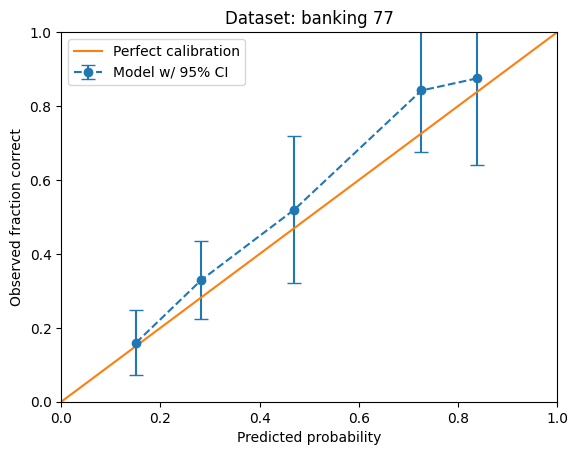

In [43]:
plot_calibration_curve(
    df_tr_mini["label"] == pred_probs_small_prompt.argmax(axis=1),
    pred_probs_small_prompt.max(axis=1),
    n_bins=5,
    title="Dataset: banking 77",
)

That's pretty good considering there are 77 classes. One application of calibrated
probabilities is that they make auto-approval systems easy to configure: you can
immediately guess-timate a threshold for the smallest probabilty that meets some
requirement on correctness. I'll flesh out auto-approval in a different notebook.

Let's see how calibrated the bigger, more discriminative prompt is.

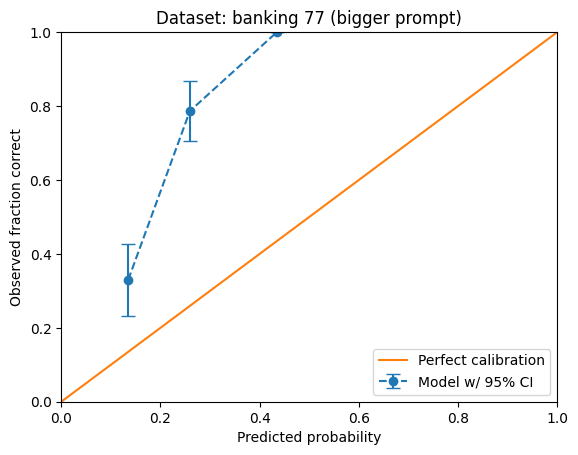

In [44]:
plot_calibration_curve(
    df_tr_mini["label"] == pred_probs.argmax(axis=1),
    pred_probs.max(axis=1),
    n_bins=5,
    title="Dataset: banking 77 (bigger prompt)",
)

Weird. It's not as calibrated. It's highly underconfident; it allocates too much probability to the 76 wrong (but perhaps plausible?) classes. Maybe it's still better for auto-approval applications. I'll take a look later.